In [16]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [17]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [18]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

# print(bhArray.shape)
# print(sphArray.shape)

In [19]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

# np.shape(dataArray)

In [20]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [22]:
#Sjekke om device GPU er på
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [23]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [24]:
#Transofrm from numpy array to torch
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [25]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [26]:
#Transform data data to dataloader
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

Noen ting kan prøve for å forbedre modellen?
- Data augmentering
- Adjustnr layers, filters, kernel size in CNN
- Learning rate scheduling
- Wight initialization
- Use more advanced optimizer
- Regularization
- Early stopping?

In [27]:
#Symmetric net følgjer ikke noen konkret struktur til ResNet eller VGG net men har noen 
#karakteristikk til VGG med bruk av små konsolusjonslager med flere lag. 
#Og bruk av average poolign i staden for max pooling
import torch.nn as nn
import torch.nn.functional as F

class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetSymmetric(nn.Module):
    def __init__(self, dropout):
        super(ResNetSymmetric, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        self.layer1 = BasicResBlock(64, 128, stride=2)
        self.layer2 = BasicResBlock(128, 256, stride=2)
        self.layer3 = BasicResBlock(256, 512, stride=2)
        
        self.fc1 = nn.Linear(512 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x_flipped_horizontal = torch.flip(x, [3])  # flip horizontally
        x_flipped_vertical = torch.flip(x, [2])  # flip vertically
        x_rotated_180 = torch.rot90(x, 2, [2, 3])  # rotate 180
        
        x = self.pool1(x)
        x_flipped_horizontal = self.pool1(x_flipped_horizontal)
        x_flipped_vertical = self.pool1(x_flipped_vertical)
        x_rotated_180 = self.pool1(x_rotated_180)
        
        x = (x + x_flipped_horizontal + x_flipped_vertical + x_rotated_180) / 4
        x = self.dropout(x)
        
        x = self.layer1(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.dropout(x)
        
        x = self.layer3(x)
        x = self.dropout(x)
        
        x = x.reshape(-1, 512 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

In [28]:
from torchsummary import summary

model = SymmetricNet(dropout=0.25).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, input_size=(3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           3,584
       BatchNorm2d-2          [-1, 128, 48, 48]             256
            Conv2d-3          [-1, 128, 48, 48]           3,584
       BatchNorm2d-4          [-1, 128, 48, 48]             256
            Conv2d-5          [-1, 128, 48, 48]           3,584
       BatchNorm2d-6          [-1, 128, 48, 48]             256
            Conv2d-7          [-1, 128, 48, 48]           3,584
       BatchNorm2d-8          [-1, 128, 48, 48]             256
         AvgPool2d-9          [-1, 128, 24, 24]               0
        AvgPool2d-10          [-1, 128, 24, 24]               0
        AvgPool2d-11          [-1, 128, 24, 24]               0
        AvgPool2d-12          [-1, 128, 24, 24]               0
          Dropout-13          [-1, 128, 24, 24]               0
           Conv2d-14          [-1, 256,

Koden under utfører treningen og plotter alt i noen utvalgte grafer, må ryddes i for å få bedre oversikt!

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train(model, train_loader, test_loader, optimizer, criterion, n_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize lists to store the metrics
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    black_holes_accs = []
    sphalerons_accs = []
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        correct = 0
        total = 0
    
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 1, 2)).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100 * correct / total
        train_loss /= len(train_loader)

        # Test
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        black_holes_correct = 0
        sphalerons_correct = 0
        black_holes_total = 0
        sphalerons_total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device).long()
                outputs = model(inputs.permute(0, 3, 1, 2)).float()
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Separate accuracies
                black_holes_correct += (predicted * labels).sum().item()
                sphalerons_correct += ((1 - predicted) * (1 - labels)).sum().item()
                black_holes_total += labels.sum().item()
                sphalerons_total += (1 - labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_acc = 100 * correct / total
        black_holes_acc = 100 * black_holes_correct / black_holes_total
        sphalerons_acc = 100 * sphalerons_correct / sphalerons_total
        test_loss /= len(test_loader)

        # Print results
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

        # Append the metrics to the lists
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        black_holes_accs.append(black_holes_acc)
        sphalerons_accs.append(sphalerons_acc)

    # Plot the metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')

    plt.subplot(2, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(black_holes_accs, label='Black Holes Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Black Holes Accuracy')

    plt.subplot(2, 2, 4)
    plt.plot(sphalerons_accs, label='Sphalerons Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Sphalerons Accuracy')

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0, 1], ['Black Holes', 'Sphalerons'])
    plt.yticks([0, 1], ['Black Holes', 'Sphalerons'])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=16)

    plt.colorbar()
    plt.show()



Epoch 1/5
Train Loss: 0.3642, Train Accuracy: 84.82%
Test Loss: 0.2882, Test Accuracy: 87.79%
Epoch 2/5
Train Loss: 0.2904, Train Accuracy: 88.21%
Test Loss: 0.2446, Test Accuracy: 90.11%
Epoch 3/5
Train Loss: 0.2681, Train Accuracy: 89.48%
Test Loss: 0.2655, Test Accuracy: 88.81%
Epoch 4/5
Train Loss: 0.2505, Train Accuracy: 90.16%
Test Loss: 0.2569, Test Accuracy: 89.52%
Epoch 5/5
Train Loss: 0.2481, Train Accuracy: 90.51%
Test Loss: 0.2099, Test Accuracy: 92.00%


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

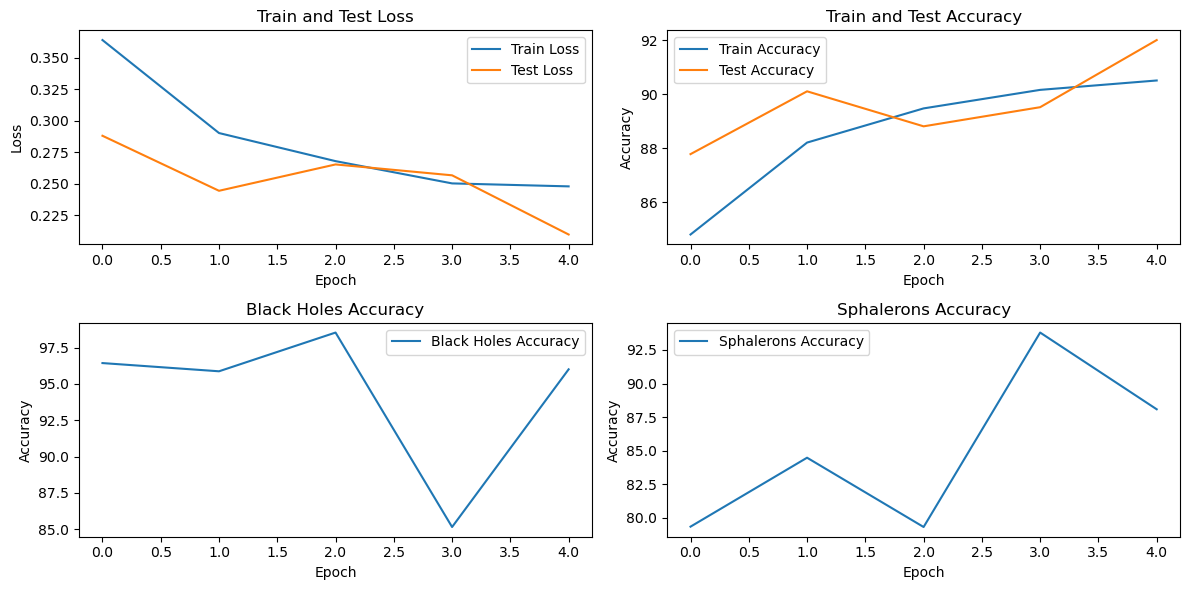

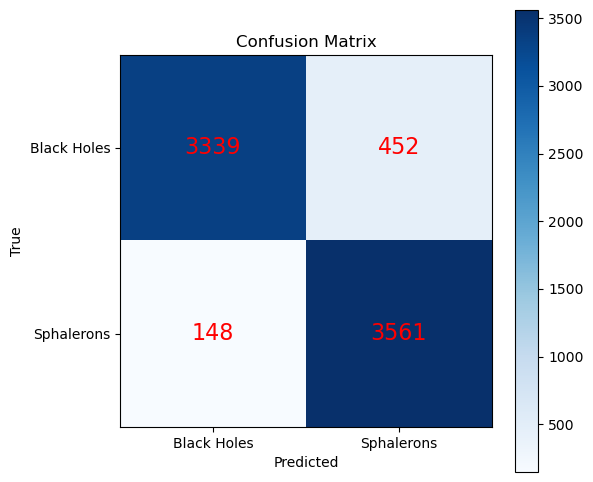

In [32]:
# Set the learning rate and number of epochs
n_epochs = 5

# Create the model
model = SymmetricNet(0.5).to(device)

# Set up the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train the model
train(model, trainLoader, testLoader, optimizer, criterion, n_epochs)

Code below makes it possible to save model

In [ ]:
# Define the file path to save the trained model
# model_path = 'model.pth'

# Train and save the model
# train(model, train_loader, test_loader, optimizer, criterion, n_epochs)
# torch.save(model.state_dict(), model_path)

In [ ]:
# # Define the file path to load the saved model
# model_path = 'model.pth'

# # Create an instance of the model and load the saved state dictionary
# model = SymmetricNet(dropout=0.25)
# model.load_state_dict(torch.load(model_path))